# VGG16をKerasで使うサンプル

学習済みのVGG16をKerasで使って、簡単な画像判別を行うサンプル。

In [1]:
from keras.applications.vgg16 import VGG16, preprocess_input, decode_predictions
from keras.preprocessing import image
import requests
import numpy as np
import shap
import json

import tensorflow
from tensorflow.compat.v1.keras.backend import get_session

tensorflow.compat.v1.disable_v2_behavior()


Instructions for updating:
non-resource variables are not supported in the long term


In [2]:
MAX_RESULT = 2

In [3]:
model = VGG16(include_top=True, weights='imagenet', input_tensor=None, input_shape=None)

In [4]:
model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [5]:
def get_image(url, file_name):
    req = requests.get(url, stream=True)
    if req.status_code == 200:
        return req.content

        

In [6]:
url = 'https://upload.wikimedia.org/wikipedia/commons/9/98/NTB_publ.jpg'
file_name = 'hoge.jpg'

with open(file_name, 'wb') as f:
    f.write(get_image(url, file_name))

img = image.load_img(file_name, target_size=(224, 224))

image_array = image.img_to_array(img)

image_array = np.expand_dims(image_array, axis=0)

preds = model.predict(preprocess_input(image_array))
results = decode_predictions(preds, top=MAX_RESULT)[0]
for result in results:
    print(result)

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
('n03930313', 'picket_fence', 0.8690901)
('n04604644', 'worm_fence', 0.09655064)


In [7]:
def map2layer(x, layer):
    feed_dict = dict(zip([model.layers[0].input], [preprocess_input(x.copy())]))
    return get_session().run(model.layers[layer].input, feed_dict)

In [8]:
X, y = shap.datasets.imagenet50()

In [9]:
LAYER = 7

In [10]:
e = shap.GradientExplainer(
    (model.layers[LAYER].input, model.layers[-1].output),
    map2layer(X, LAYER),
    local_smoothing=0 # std dev of smoothing noise
)

In [11]:
url = "https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json"
fname = shap.datasets.cache(url)
with open(fname) as f:
    class_names = json.load(f)

In [12]:
shap_values, indexes = e.shap_values(map2layer(image_array, LAYER), ranked_outputs=MAX_RESULT, output_rank_order='max')

In [13]:
index_names = np.vectorize(lambda x: class_names[str(x)][1])(indexes)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


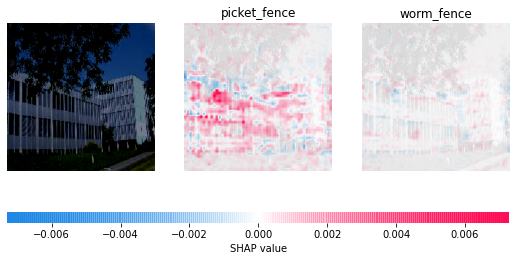

In [14]:
shap.image_plot(shap_values, image_array, index_names)